<a href="https://colab.research.google.com/github/jhc154/PatentLandscapeViz/blob/master/GooglePatent_Analysis_Semiconductors_20200511.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook to go along with medium post


In [0]:
# use if using google colab
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
# import pandas
import pandas as pd
import os

In [0]:
# Start Here by changing directory that contains the target csv

In [0]:
# change directory based on your environment
os.chdir('/content/gdrive/My Drive/GDATA/IP_Investments')

In [0]:
# create variables to point to a file to be analyzed, currently set to asic

# available in the github repo
asic = 'gp-search-20200505-172536-raw_with_claims_RERUN.csv'
graphene = 'gp-search-20200505-172109-raw_with_claims.csv'

# read in the csv file containing patent data

df = pd.read_csv(graphene, index_col=0) # switch variables here or the csv file name

import time # need to have date fields recognized as such

# priority date
df['priority date'] = pd.to_datetime(df['priority date'])
# filing date
df['filing/creation date'] = pd.to_datetime(df['filing/creation date'])
# publication date
df['publication date'] = pd.to_datetime(df['publication date'])
# grant date. Some are not granted, so we tell pandas to ignore if they won't turn into datetime format
df['grant date'] = pd.to_datetime(df['grant date'], errors = 'ignore')

In [59]:
df.head() # see what we're dealing with

,id,title,assignee,inventor/author,priority date,filing/creation date,publication date,grant date,result link,representative figure link,claim,classifications,citedBy
0,US-8890277-B2,Graphite and/or graphene semiconductor devices,University Of Florida Research Foundation Inc.,"Arthur Foster Hebard, Sefaattin Tongay",2010-03-15,2011-03-14,2014-11-18,2014-11-18,https://patents.google.com/patent/US8890277B2/en,https://patentimages.storage.googleapis.com/b9...,"Claims (20)\nHide Dependent\nTherefore, at lea...",Classifications\n\nH01L29/1606 Graphene\nView ...,Cited By (22)
1,US-8044472-B2,Nanotube and graphene semiconductor structures...,"Kulite Semiconductor Products, Inc.","Anthony D. Kurtz, Adam Hurst",2003-03-25,2010-01-22,2011-10-25,2011-10-25,https://patents.google.com/patent/US8044472B2/en,https://patentimages.storage.googleapis.com/5b...,Claims (14)\nHide Dependent\n1. A transducer c...,Classifications\n\nG01L1/005 Measuring force o...,Cited By (31)
2,US-8872159-B2,Graphene on semiconductor detector,"The United States Of America, As Represented B...","Francis J. Kub, Travis Anderson, Karl D. Hobart",2011-09-29,2012-09-28,2014-10-28,2014-10-28,https://patents.google.com/patent/US8872159B2/en,https://patentimages.storage.googleapis.com/21...,Claims (29)\nHide Dependent\nThe following is ...,Classifications\n\nH01L31/028 Inorganic materi...,Cited By (62)
3,US-8716766-B2,"Graphene semiconductor device, manufacturing m...","Samsung Electronics Co., Ltd.","Chang-seung Lee, Young Bae Kim, Young Jun Yun,...",2012-04-03,2012-06-14,2014-05-06,2014-05-06,https://patents.google.com/patent/US8716766B2/en,https://patentimages.storage.googleapis.com/d0...,Claims (20)\nHide Dependent\nWhat is claimed i...,Classifications\n\nH01L29/7391 Gated diode str...,Cited By (15)
4,US-9269764-B2,Graphene semiconductor and electrical device i...,"Samsung Electronics Co., Ltd.","Jong-ryoul AHN, Jeong-tak SEO, Ji-hoon Park, C...",2012-08-01,2013-05-30,2016-02-23,2016-02-23,https://patents.google.com/patent/US9269764B2/en,https://patentimages.storage.googleapis.com/74...,Claims (14)\nHide Dependent\nWhat is claimed i...,Classifications\n\nH01L29/06 Semiconductor bod...,Cited By (11)


In [0]:
# also change the col name from id to patent
df.rename(columns={'id':'patent'}, inplace=True)

In [0]:
# fix error related to float type error when trying to process these cols; 
# make sure these cols are read in as string types

df['claim'] = df['claim'].astype(str)
df['classifications'] = df['classifications'].astype(str)

In [62]:
# check for bad data and count it 
df_na_any = df.dropna(how = 'any')
print("NA len(any): ", len(df_na_any))
print()
df_na_subset = df.dropna(subset=['claim'])
print("NA len(subset): ", len(df_na_subset))
print()
print("DF len: ", len(df))

NA len(any):  6611

NA len(subset):  7831

DF len:  7831


In [0]:
# change df if necessary, uncomment below
 df = df.dropna(how = 'any')

In [0]:
# Words that should be excluded from anaysis; patent claims generally contain similar words or 'terms of art' that are necessary for claim construction
# but profoundly useless for conveying the meaning of an invention. 

stop_list = ['based', 'having', 'material', 'materials','according','abstract','abstracts','acceptable','apparatus','apparatuses',\
             'body','cancel','claim','claims','claimed','following','classification',\
             'classifications','comprise','comprises','comprising','composition','optionally','compound',\
             'portion', 'portions', 'consisting','configure','configures','consist','consists','configured','dependent','desire','description',\
             'device','devices','disclose','disclosed','discloses','different', 'surface', 'using', 'substrate', 'surface', 'layer',\
             'embodiment','embodiments','example','examples','non', 'portion', 'selected',\
             'disposed', 'formed', 'forming','for example','herein','hide','include','includes','invention',\
             'inventions','inventions','method','produce','present','process','provide',\
             'provided','provides','plurality','said','say','system','systems',\
             'thereof','user','subject','subsequent', 'cite', 'cited',\
             'form','group','use', 'select', 'little', 'accord','first', 'second', 'third', 'fourth', 'fifth', 'sixth','seventh'] 

In [0]:
#import libraries and prep to clean and tokenize raw text


# install and import spacy (look up documentation for spacy)
import spacy

# import English package
from spacy.lang.en import English

# import string library
import string

# import regex to help clean text
import re

# import scikit learn package of English stop words 
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

# assign variable "punctuation" to list of punctuations from string package
punctuation = list(string.punctuation)

# assign variable "parser" to the English function
parser = English()

In [0]:
# Create a function to clean and tokenize raw text
def tokenizeText(text):
    # clean text using regex
    ## create a list of regex expressions and assign variable "separators"
    separators = ["\xa0\xa0\xa0\xa0", "\r", "\n",\
                  "\t", "n't", "'m", "'ll", '[^a-z ]'\
                 '[\s]+',r'[^\w]','^\d+\s|\s\d+\s|\s\d+$']
    
    # iterate over the list of separators
    for i in separators:
        # every time regex finds a match in the text of the claims, delete (replace it with space)
        text = re.sub(i, " ", text.lower())
    
    # parse text using Spacy
    tokens = parser(text)
    tokens = [tok.lemma_.strip() for tok in tokens]
    # get rid of words in the stop list
    
    return [tok for tok in tokens if len(tok) !=1 and tok not in stop]

In [0]:
# create function to turn the list of tokens into one body of text (corpus)
def text_processing(corp):
    # call the tokenizeText function we created above
    corp = tokenizeText(corp)
    return ' '.join(corp)

In [0]:
stop = set(list(stop_list) + list(ENGLISH_STOP_WORDS) + list(punctuation))

In [0]:
# apply the function for each row of texts in the text column of the dataframe
df['claim'] = df['claim'].apply(text_processing)
df['classifications'] = df['classifications'].apply(text_processing)

In [0]:
# remove white space from the cells containing classification data; to help with extracting the classification number
# this code has some bugs that need to be worked out, some cells are producing nan
df['classifications'] = df['classifications'].str.strip()


In [71]:
# extract the first part of classification cell, the number and create a temp DF to hold these
temp = df['classifications'].str.split(" ", n=1, expand=True).astype(str)
temp.head()

,0,1
0,h01l29,graphene view
1,g01l1,measuring force stress general electrical mean...
2,h01l31,inorganic including apart doping impurities el...
3,h01l29,gated diode structures view
4,h01l29,semiconductor bodies multistep manufacturing ...


In [0]:
# replace df cols with the newly split classificationsNum and classification
df['classificationsNum'] = temp[0]
df.classifications = temp[1]

In [0]:
# Extract the numerical value from the cited by column (how many times this patent is cited)
# https://stackoverflow.com/questions/37683558/pandas-extract-number-from-string

df['citedBy'] = df.citedBy.str.extract('(\d+)')

In [74]:
# check handy work so far >>> cols from let to right
df.head()

,patent,title,assignee,inventor/author,priority date,filing/creation date,publication date,grant date,result link,representative figure link,claim,classifications,citedBy,classificationsNum
0,US-8890277-B2,Graphite and/or graphene semiconductor devices,University Of Florida Research Foundation Inc.,"Arthur Foster Hebard, Sefaattin Tongay",2010-03-15,2011-03-14,2014-11-18,2014-11-18,https://patents.google.com/patent/US8890277B2/en,https://patentimages.storage.googleapis.com/b9...,schottky diode semiconductor including semico...,graphene view,22,h01l29
1,US-8044472-B2,Nanotube and graphene semiconductor structures...,"Kulite Semiconductor Products, Inc.","Anthony D. Kurtz, Adam Hurst",2003-03-25,2010-01-22,2011-10-25,2011-10-25,https://patents.google.com/patent/US8044472B2/en,https://patentimages.storage.googleapis.com/5b...,transducer graphene semiconductive structures...,measuring force stress general electrical mean...,31,g01l1
2,US-8872159-B2,Graphene on semiconductor detector,"The United States Of America, As Represented B...","Francis J. Kub, Travis Anderson, Karl D. Hobart",2011-09-29,2012-09-28,2014-10-28,2014-10-28,https://patents.google.com/patent/US8872159B2/en,https://patentimages.storage.googleapis.com/21...,detector semiconductor structure graphene sem...,inorganic including apart doping impurities el...,62,h01l31
3,US-8716766-B2,"Graphene semiconductor device, manufacturing m...","Samsung Electronics Co., Ltd.","Chang-seung Lee, Young Bae Kim, Young Jun Yun,...",2012-04-03,2012-06-14,2014-05-06,2014-05-06,https://patents.google.com/patent/US8716766B2/en,https://patentimages.storage.googleapis.com/d0...,manufacturing graphene semiconductor multilay...,gated diode structures view,15,h01l29
4,US-9269764-B2,Graphene semiconductor and electrical device i...,"Samsung Electronics Co., Ltd.","Jong-ryoul AHN, Jeong-tak SEO, Ji-hoon Park, C...",2012-08-01,2013-05-30,2016-02-23,2016-02-23,https://patents.google.com/patent/US9269764B2/en,https://patentimages.storage.googleapis.com/74...,graphene semiconductor graphene metal atomic ...,semiconductor bodies multistep manufacturing ...,11,h01l29


In [0]:
#clean up white space, just making sure
df['title'] = df['title'].str.strip()
df['claim'] = df['claim'].str.strip()
df['classifications'] = df['classifications'].str.strip()
df['citedBy'] = df['citedBy'].str.strip()

In [76]:
#reset index, just making sure
df = df.reset_index(drop=True)
df.head()

,patent,title,assignee,inventor/author,priority date,filing/creation date,publication date,grant date,result link,representative figure link,claim,classifications,citedBy,classificationsNum
0,US-8890277-B2,Graphite and/or graphene semiconductor devices,University Of Florida Research Foundation Inc.,"Arthur Foster Hebard, Sefaattin Tongay",2010-03-15,2011-03-14,2014-11-18,2014-11-18,https://patents.google.com/patent/US8890277B2/en,https://patentimages.storage.googleapis.com/b9...,schottky diode semiconductor including semicon...,graphene view,22,h01l29
1,US-8044472-B2,Nanotube and graphene semiconductor structures...,"Kulite Semiconductor Products, Inc.","Anthony D. Kurtz, Adam Hurst",2003-03-25,2010-01-22,2011-10-25,2011-10-25,https://patents.google.com/patent/US8044472B2/en,https://patentimages.storage.googleapis.com/5b...,transducer graphene semiconductive structures ...,measuring force stress general electrical mean...,31,g01l1
2,US-8872159-B2,Graphene on semiconductor detector,"The United States Of America, As Represented B...","Francis J. Kub, Travis Anderson, Karl D. Hobart",2011-09-29,2012-09-28,2014-10-28,2014-10-28,https://patents.google.com/patent/US8872159B2/en,https://patentimages.storage.googleapis.com/21...,detector semiconductor structure graphene semi...,inorganic including apart doping impurities el...,62,h01l31
3,US-8716766-B2,"Graphene semiconductor device, manufacturing m...","Samsung Electronics Co., Ltd.","Chang-seung Lee, Young Bae Kim, Young Jun Yun,...",2012-04-03,2012-06-14,2014-05-06,2014-05-06,https://patents.google.com/patent/US8716766B2/en,https://patentimages.storage.googleapis.com/d0...,manufacturing graphene semiconductor multilaye...,gated diode structures view,15,h01l29
4,US-9269764-B2,Graphene semiconductor and electrical device i...,"Samsung Electronics Co., Ltd.","Jong-ryoul AHN, Jeong-tak SEO, Ji-hoon Park, C...",2012-08-01,2013-05-30,2016-02-23,2016-02-23,https://patents.google.com/patent/US9269764B2/en,https://patentimages.storage.googleapis.com/74...,graphene semiconductor graphene metal atomic g...,semiconductor bodies multistep manufacturing ...,11,h01l29


In [77]:
len(df)

6611

In [0]:
## at this point, text has been processed and cleaned, ready for analysis
#df.to_csv('gp-search-20200505-172109-raw_with_claims_cleaned_RERUN.csv') # save to csv if desired

In [79]:
df.head()

,patent,title,assignee,inventor/author,priority date,filing/creation date,publication date,grant date,result link,representative figure link,claim,classifications,citedBy,classificationsNum
0,US-8890277-B2,Graphite and/or graphene semiconductor devices,University Of Florida Research Foundation Inc.,"Arthur Foster Hebard, Sefaattin Tongay",2010-03-15,2011-03-14,2014-11-18,2014-11-18,https://patents.google.com/patent/US8890277B2/en,https://patentimages.storage.googleapis.com/b9...,schottky diode semiconductor including semicon...,graphene view,22,h01l29
1,US-8044472-B2,Nanotube and graphene semiconductor structures...,"Kulite Semiconductor Products, Inc.","Anthony D. Kurtz, Adam Hurst",2003-03-25,2010-01-22,2011-10-25,2011-10-25,https://patents.google.com/patent/US8044472B2/en,https://patentimages.storage.googleapis.com/5b...,transducer graphene semiconductive structures ...,measuring force stress general electrical mean...,31,g01l1
2,US-8872159-B2,Graphene on semiconductor detector,"The United States Of America, As Represented B...","Francis J. Kub, Travis Anderson, Karl D. Hobart",2011-09-29,2012-09-28,2014-10-28,2014-10-28,https://patents.google.com/patent/US8872159B2/en,https://patentimages.storage.googleapis.com/21...,detector semiconductor structure graphene semi...,inorganic including apart doping impurities el...,62,h01l31
3,US-8716766-B2,"Graphene semiconductor device, manufacturing m...","Samsung Electronics Co., Ltd.","Chang-seung Lee, Young Bae Kim, Young Jun Yun,...",2012-04-03,2012-06-14,2014-05-06,2014-05-06,https://patents.google.com/patent/US8716766B2/en,https://patentimages.storage.googleapis.com/d0...,manufacturing graphene semiconductor multilaye...,gated diode structures view,15,h01l29
4,US-9269764-B2,Graphene semiconductor and electrical device i...,"Samsung Electronics Co., Ltd.","Jong-ryoul AHN, Jeong-tak SEO, Ji-hoon Park, C...",2012-08-01,2013-05-30,2016-02-23,2016-02-23,https://patents.google.com/patent/US9269764B2/en,https://patentimages.storage.googleapis.com/74...,graphene semiconductor graphene metal atomic g...,semiconductor bodies multistep manufacturing ...,11,h01l29


Parameters for ASIC: min_df = 0.01, max_df = .25
Parameters for Graphene: min_df = , max_df = 

In [0]:
# TF-IDF vectorizer

# import libraries
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pandas as pd
                  
tfidf_vectorizer = TfidfVectorizer(
    min_df=0.01, 
    max_df=0.25, 
    max_features=5000)
    
tfidf_matrix = tfidf_vectorizer.fit_transform(df.claim)

In [81]:
vectorizer0 = CountVectorizer()
X0 = vectorizer0.fit_transform(df.claim)
print(X0.shape)
print(vectorizer0.vocabulary_)

vectorizer1 = CountVectorizer(
    min_df=0.01, 
    max_df=0.25,
    max_features = 5000)
X1 = vectorizer1.fit_transform(df.claim)

print(X1.shape)
print(vectorizer1.vocabulary_)

vectorizer2 = CountVectorizer(
    min_df=0.1, 
    max_df=0.25,
    max_features = 5000)
X2 = vectorizer2.fit_transform(df.claim)
print(X2.shape)
print(vectorizer2.vocabulary_)

vectorizer3 = CountVectorizer(
    min_df=0.1, 
    max_df=0.3, # tested up to .8
    max_features = 5000)
X3 = vectorizer3.fit_transform(df.claim)
print(X3.shape)
print(vectorizer3.vocabulary_)

(6611, 27658)
{'schottky': 22113, 'diode': 7737, 'semiconductor': 22315, 'including': 12473, 'semiconducting': 22312, 'semimetal': 22321, 'stack': 23439, 'graphene': 10982, 'barrier': 2855, 'ohmic': 17251, 'contact': 5730, 'height': 11360, 'range': 20826, 'ev': 9324, 'doped': 8217, 'intercalated': 12864, 'impurity': 12397, 'atoms': 2539, 'bromine': 3669, 'graphite': 10992, 'sub': 23743, 'layers': 13815, 'sic': 22597, 'gan': 10571, 'opposite': 17372, 'common': 5414, 'partially': 17904, 'encircles': 8866, 'rubidium': 21863, 'cesium': 4585, 'sbcl5': 22043, 'so3': 23042, 'sbf5': 22045, 'highly': 11693, 'oriented': 17492, 'pyrolytic': 20454, 'gold': 10923, 'iii': 12208, 'chloride': 4847, 'aucl3': 2592, 'bis': 3334, 'trifluoromethanesulfonyl': 25614, 'amine': 1804, 'single': 22749, 'atomic': 2532, 'unaligned': 25929, 'transducer': 25350, 'semiconductive': 22313, 'structures': 23708, 'located': 14248, 'entirely': 8981, 'supported': 24061, 'entire': 8980, 'length': 13886, 'electrical': 8604, '

In [82]:
# examples of showing the matrix and counting terms 

vectorizer = CountVectorizer(
    min_df=0.01, 
    max_df=0.25,
    max_features = 5000)

# Use the content column instead of our single text variable
matrix = vectorizer.fit_transform(df.claim)
counts = pd.DataFrame(matrix.toarray(),
                  index=df.patent,
                  columns=vectorizer.get_feature_names())

counts.head()
#counts.to_csv('counts_asic_rerun_6628_min001.csv')


,00,000,10,11,12,13,14,15,16,17,18,19,20,2d,3d,50,absence,absorbing,absorption,ac,acceptor,access,accordance,acetate,acetylene,acid,acrylic,activated,activating,activation,active,actuator,adapted,added,adding,additional,additive,address,adhesion,adhesive,...,view,vinyl,visible,volatile,voltage,voltages,volume,wafer,wall,walled,walls,water,wave,waveguide,wavelength,wavelengths,way,weight,wet,white,width,window,wire,wireless,wires,wiring,word,work,write,writing,wt,zero,zinc,zirconium,zn,zno,zone,zr,zro2,μm
patent,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
US-8890277-B2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
US-8044472-B2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
US-8872159-B2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,1,0,0,0,0,0,0,0,...,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
US-8716766-B2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
US-9269764-B2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [83]:
counts.sum(axis=0)

00       617
000      240
10       626
11       191
12       170
        ... 
zno      387
zone    1062
zr       305
zro2      95
μm      1999
Length: 1431, dtype: int64

In [84]:
# baseline idea of when everything is being counted

vectorizer = CountVectorizer()

matrix = vectorizer.fit_transform(df.claim)
counts = pd.DataFrame(matrix.toarray(),
                      columns=vectorizer.get_feature_names())

# Show us the top 10 most common words
counts.T.sort_values(by=0, ascending=False).head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,6571,6572,6573,6574,6575,6576,6577,6578,6579,6580,6581,6582,6583,6584,6585,6586,6587,6588,6589,6590,6591,6592,6593,6594,6595,6596,6597,6598,6599,6600,6601,6602,6603,6604,6605,6606,6607,6608,6609,6610
stack,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,17,0,0,0,0,0,0,16,2,0,0,0,0,3,0,0,0,0,0,0,0,6,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
semimetal,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
schottky,24,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
diode,19,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0
semiconductor,16,0,49,47,12,20,1,30,0,0,3,0,0,11,0,19,0,0,0,14,0,0,2,0,0,2,17,3,1,0,18,22,7,14,2,3,0,0,1,0,...,0,0,0,0,26,0,0,20,8,0,0,11,0,0,1,4,0,7,0,0,2,14,0,0,2,0,0,0,0,0,0,0,17,100,15,6,1,0,0,0
graphene,10,12,24,29,23,42,1,3,4,15,21,38,15,24,28,18,6,33,1,11,8,22,9,13,18,4,36,32,10,48,52,2,30,9,0,0,2,0,1,4,...,0,0,0,0,0,13,26,0,0,6,5,0,1,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,41,0,0,0,0,0,0,0,0,0,0
contact,10,2,27,0,0,2,2,0,2,2,0,2,0,0,0,4,2,26,2,0,0,0,0,12,4,4,0,0,0,0,1,6,2,2,3,0,1,0,0,0,...,0,0,1,0,1,8,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,2,0,0,0,16,7,4,0,0,0,2
including,7,0,8,5,0,4,0,0,1,0,2,0,0,0,0,0,4,7,0,1,1,0,2,0,1,0,0,0,0,2,0,11,2,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,7,1,1,0,16,3,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
ohmic,6,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
graphite,5,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,8,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [85]:
counts.sum(axis=0)

00        617
000       240
0000        2
00000       5
000001      2
         ... 
ωj          2
ωm          4
ωt          1
ωμm2        2
⅓rd         1
Length: 27658, dtype: int64

In [0]:
# find cosine similarities for recommendation engine (Data Camp)

from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [0]:
# Generate mapping between titles and index (Data Camp)

indices = pd.Series(df.index, index=df['patent'])

def get_recommendations(patent, cosine_sim, indices):
    # Get index of patent that matches title
    idx = indices[patent]
    # Sort the patents based on the similarity scores
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Get the scores for 10 most similar matches
    sim_scores = sim_scores[1:11]
    # Get the indices
    patent_indices = [i[0] for i in sim_scores]
    # Return the top 10 most similar movies
    return df[['patent','title','classificationsNum']].iloc[patent_indices]

In [89]:
# test recommender, input patent ID and return similar patents

# analysis: is the algorithm right if similar classificationsNum are returned or is it finding patents that are more related than they seem?
# argA: classificationsNum are already a form of classification about the patent document - one should expect to see very similar numbers
# argB: the similiarities of the actual patents indiciate more similarity than their classification number - this is a new insight. 

asic_test = 'US-7587699-B2'
graphene_test ='US-8716766-B2'

print(get_recommendations(graphene_test, cosine_sim, indices))

              patent  ... classificationsNum
6017   US-9705549-B1  ...              h04b1
6547   US-8416603-B2  ...             b82y30
743    US-9770894-B2  ...             b32b43
5752  US-10015844-B2  ...              h05b3
4711   US-9096434-B2  ...             c01b31
4397  US-10074788-B2  ...             h01l33
6305   US-9184210-B2  ...             h01l27
4378  US-10347700-B2  ...             h01l27
4582   US-9269921-B2  ...             h01l33
2552   US-8508276-B2  ...             h03k19

[10 rows x 3 columns]


In [0]:
# set number of clusters; start at 8 and then tune down based on elbow analysis
k = 8

In [0]:
# pca analysis of tf_idf_matrix

from sklearn.decomposition import PCA

#keep n_components at 10, max 20; just for exploratory analysis
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(tfidf_matrix.todense())
PCA_components = pd.DataFrame(principalComponents)

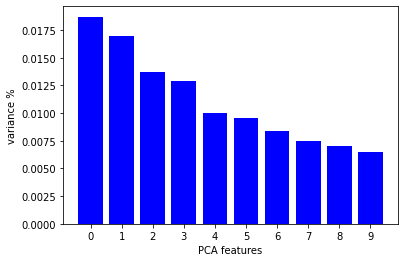

In [92]:
# plot pca analysis variance
import matplotlib.pyplot as plt

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='blue')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features);

In [93]:
print(pca.n_components_)

10


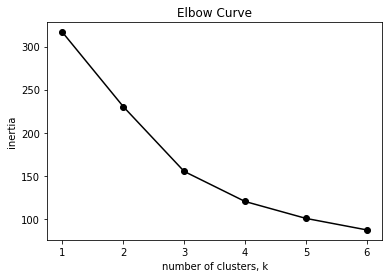

In [95]:
#run elbow analysis; identify ideal # clusters with KMeans and PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

ks = range(1, k)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.title('Elbow Curve')

#plt.savefig('PatentViz-ASIC-FGPA.png')
plt.show()

In [96]:
# fit tf_idf matrix to KMeans clusters; accept all values (runs much faster in colab than on my laptop)
km = KMeans(n_clusters=k)
km.fit(tfidf_matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
# send KMeans cluster labels to list 'clusters'
# http://brandonrose.org/clustering

from sklearn.externals import joblib

joblib.dump(km,  'doc_cluster.pkl')

km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [98]:
# add cluster values to dataframe
df['cluster'] = clusters

# need to make citedBy number as int type
df['citedBy'] = df['citedBy'].fillna(0).astype(int)

#df['DataFrame Column'] = df['DataFrame Column'].fillna(0)
grouped = df['citedBy'].groupby(df['cluster'])

grouped.mean()

cluster
0    15.445122
1    16.539451
2    15.920821
3    12.618280
4    13.774772
5    12.230882
Name: citedBy, dtype: float64

In [0]:
# create an empty dict for cluster names
cluster_names = {}

In [100]:
df.head()

,patent,title,assignee,inventor/author,priority date,filing/creation date,publication date,grant date,result link,representative figure link,claim,classifications,citedBy,classificationsNum,cluster
0,US-8890277-B2,Graphite and/or graphene semiconductor devices,University Of Florida Research Foundation Inc.,"Arthur Foster Hebard, Sefaattin Tongay",2010-03-15,2011-03-14,2014-11-18,2014-11-18,https://patents.google.com/patent/US8890277B2/en,https://patentimages.storage.googleapis.com/b9...,schottky diode semiconductor including semicon...,graphene view,22,h01l29,4
1,US-8044472-B2,Nanotube and graphene semiconductor structures...,"Kulite Semiconductor Products, Inc.","Anthony D. Kurtz, Adam Hurst",2003-03-25,2010-01-22,2011-10-25,2011-10-25,https://patents.google.com/patent/US8044472B2/en,https://patentimages.storage.googleapis.com/5b...,transducer graphene semiconductive structures ...,measuring force stress general electrical mean...,31,g01l1,4
2,US-8872159-B2,Graphene on semiconductor detector,"The United States Of America, As Represented B...","Francis J. Kub, Travis Anderson, Karl D. Hobart",2011-09-29,2012-09-28,2014-10-28,2014-10-28,https://patents.google.com/patent/US8872159B2/en,https://patentimages.storage.googleapis.com/21...,detector semiconductor structure graphene semi...,inorganic including apart doping impurities el...,62,h01l31,4
3,US-8716766-B2,"Graphene semiconductor device, manufacturing m...","Samsung Electronics Co., Ltd.","Chang-seung Lee, Young Bae Kim, Young Jun Yun,...",2012-04-03,2012-06-14,2014-05-06,2014-05-06,https://patents.google.com/patent/US8716766B2/en,https://patentimages.storage.googleapis.com/d0...,manufacturing graphene semiconductor multilaye...,gated diode structures view,15,h01l29,5
4,US-9269764-B2,Graphene semiconductor and electrical device i...,"Samsung Electronics Co., Ltd.","Jong-ryoul AHN, Jeong-tak SEO, Ji-hoon Park, C...",2012-08-01,2013-05-30,2016-02-23,2016-02-23,https://patents.google.com/patent/US9269764B2/en,https://patentimages.storage.googleapis.com/74...,graphene semiconductor graphene metal atomic g...,semiconductor bodies multistep manufacturing ...,11,h01l29,4


In [101]:
len(df)

6611

In [102]:
# loop through vectorized terms and centroidst to create list of cluster names
# BUG > Can't figure out how to send all terms[ind] values to the dict; currently writing over to produce last values of each array

# https://pythonprogramminglanguage.com/kmeans-text-clustering/

terms = tfidf_vectorizer.get_feature_names()

order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(k):
    print("Cluster %d terms:" % i, end=''),

    
    for ind in order_centroids[i, :1]:
        print(' %s' % terms[ind], end=','),

        cluster_names[i] = 'Cluster %d ' % i, terms[ind]

    print() #add whitespace
    print() #add whitespace
    

Cluster 0 terms: film,

Cluster 1 terms: polymer,

Cluster 2 terms: display,

Cluster 3 terms: emitting,

Cluster 4 terms: sensor,

Cluster 5 terms: gate,



In [103]:
# This is the bug.
# Should be: ('Cluster 0 ','sald','formula','pharmaceutically'),...
# for now, this works :(
    
cluster_names

{0: ('Cluster 0 ', 'film'),
 1: ('Cluster 1 ', 'polymer'),
 2: ('Cluster 2 ', 'display'),
 3: ('Cluster 3 ', 'emitting'),
 4: ('Cluster 4 ', 'sensor'),
 5: ('Cluster 5 ', 'gate')}

In [0]:
# set up colors per clusters using a dict
# http://brandonrose.org/clustering
cluster_colors = {0: '#EC7063', 1: '#C39BD3', 2: '#7FB3D5', 3: '#48C9B0', 4: '#F1C40F', 5:'#BDC3C7', 6:'#000000'}


In [0]:
# calculate cosine similiarity
# http://brandonrose.org/clustering
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

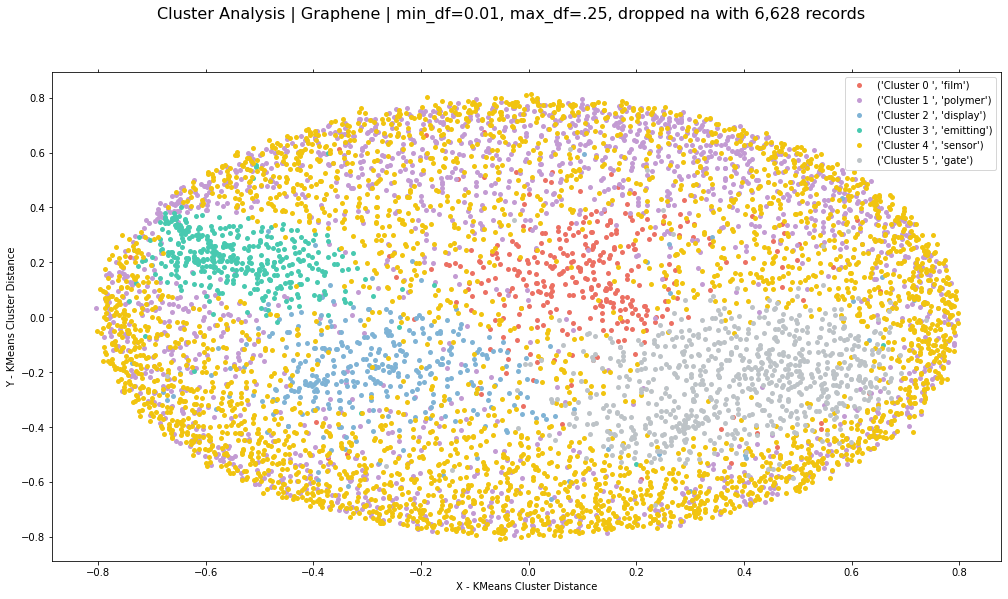

In [106]:
# transform the matrix to 2d for plotting
# takes a while to run, but still really fast in Google Colab
# http://brandonrose.org/clustering

import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

# send df patent col to a list for later when plotting
titles = df['patent'].values.tolist()

# plot the data!
# http://brandonrose.org/clustering

# some ipython magic to show the matplotlib plots inline
%matplotlib inline 

# create data frame that has the result of the MDS plus the cluster numbers and titles
df_plot = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

# patents as a key with x/y plots and clusters
df_plot.to_csv('Graphene_Patents_plot_20200512.csv')

# all the data from cleaning, etc. shared key is patent number
df.to_csv('Graphene_Patents_main_20200512.csv')

# group by cluster
groups = df_plot.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size

#added a figure title
fig.suptitle('Cluster Analysis | Graphene | min_df=0.01, max_df=.25, dropped na with 6,611 records', fontsize=16)
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

# iterate through groups to layer the plot
# note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=5, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',         # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#added x and y labels
ax.set_xlabel('X - KMeans Cluster Distance')
ax.set_ylabel('Y - KMeans Cluster Distance')

# commented out labeling all features (too many!)
#add label in x,y position with the label as the title
#for i in range(len(df_plot)):
#   ax.text(df_plot.iloc[i]['x'], df_plot.iloc[i]['y'], df_plot.iloc[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

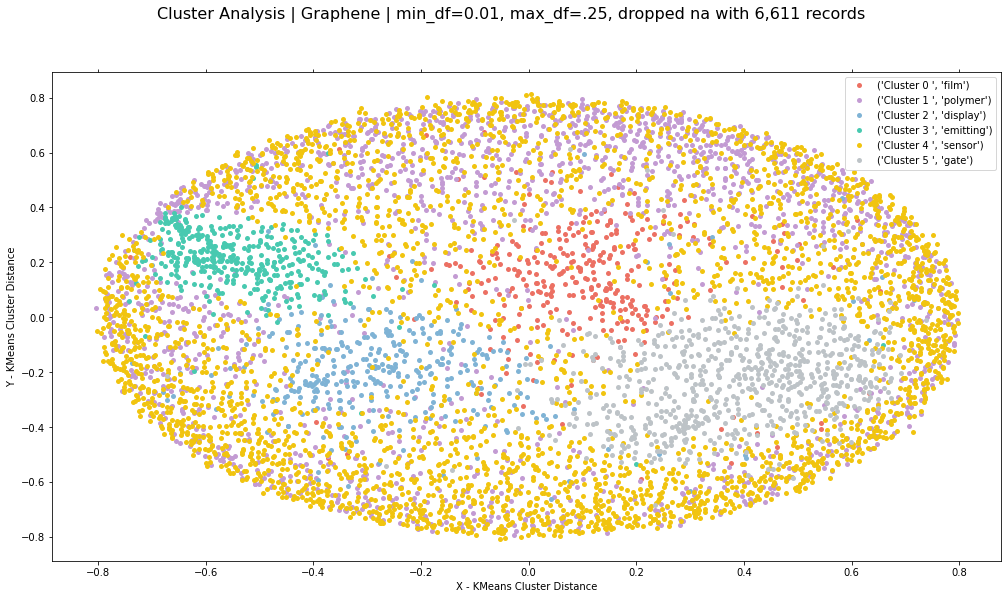

In [107]:
# some ipython magic to show the matplotlib plots inline
%matplotlib inline 

# create data frame that has the result of the MDS plus the cluster numbers and titles
df_plot = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 


# group by cluster
groups = df_plot.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size

#added a figure title
fig.suptitle('Cluster Analysis | Graphene | min_df=0.01, max_df=.25, dropped na with 6,611 records', fontsize=16)
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

# iterate through groups to layer the plot
# note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=5, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',         # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#added x and y labels
ax.set_xlabel('X - KMeans Cluster Distance')
ax.set_ylabel('Y - KMeans Cluster Distance')

# commented out labeling all features (too many!)
#add label in x,y position with the label as the title
#for i in range(len(df_plot)):
#   ax.text(df_plot.iloc[i]['x'], df_plot.iloc[i]['y'], df_plot.iloc[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

In [0]:
# export dataframes to csv for analysis and visuals in tableau

# patents as a key with x/y plots and clusters
df_plot.to_csv('Graphene_Patents_plot_20200512.csv')

# all the data from cleaning, etc. shared key is patent number
df.to_csv('Graphene_Patents_main_20200512.csv')

In [55]:
# to use d3, install the package

!pip install mpld3

     |████████████████████████████████| 798kB 4.7MB/s 
  Created wheel for mpld3: filename=mpld3-0.3-cp36-none-any.whl size=116679 sha256=ca6153947270205cd2586ffedf37e40793aa90f2665174149127e7845312f7d2
  Stored in directory: /root/.cache/pip/wheels/c0/47/fb/8a64f89aecfe0059830479308ad42d62e898a3e3cefdf6ba28
Successfully built mpld3


In [0]:
# define custom toolbar location

# http://brandonrose.org/clustering

import mpld3

class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [57]:
# plot interactive chart
# http://brandonrose.org/clustering

import mpld3

#create data frame that has the result of the MDS plus the cluster numbers and titles
df_plot2 = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df_plot2.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -200px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=5, 
                     label=cluster_names[name], mec='none', 
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
#html = mpld3.fig_to_html(fig)
#print(html)


In [76]:
# one way to run stats on the citedBy column
df.agg({'citedBy':['min','max','median','mean']})



,citedBy
min,1.000000
max,2684.000000
median,28.000000
mean,59.092336


In [0]:
# better way to analyze this table with SQL
import sqlite3

In [0]:
# establish sql connection from python
conn = sqlite3.connect('db1.db')
c = conn.cursor()

In [0]:
# create the table in SQL; send data from python dataframe to this sql table
c.execute('DROP TABLE PATENTS')
conn.commit()
c.execute('CREATE TABLE PATENTS (Patent text, Title text, Assignee text, PriorityDate date, CitedBy number, Classification text, Cluster number)')
conn.commit()

In [0]:
# create a new DF that contains all the data, minus the claim and URLs
df_sql = df[['patent', 'title', 'assignee', 'priority date', 'citedBy', 'classificationsNum', 'cluster']]

In [169]:
# send the dataframe to sql table
df_sql.to_sql('PATENTS', conn, if_exists='replace', index = False)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:2663: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  method=method,


In [0]:
# save this data to csv for analysis elsewhere (and to save it for future use); I analyzed this further in tableau

#df_sql.to_csv('Patents_ASIC_20200507_2.csv')

In [170]:
# using query features to double check results of highly cited patent
c.execute('''
SELECT * 
FROM PATENTS 
WHERE Patent="US-7587699-B2"
''')
for row in c.fetchall():
  print(row)

('US-7587699-B2', 'Automated system for designing and developing field programmable gate arrays', 'Pixel Velocity, Inc.', '2002-05-17 00:00:00', 145, 'g06f30', 4)


In [79]:
# using query features to double check results of highly cited patent
c.execute('''
SELECT * 
FROM PATENTS 
WHERE Cluster=6
ORDER BY CitedBy DESC
LIMIT (50)
''')
for row in c.fetchall():
  print(row)

('US-8467829-B2', 'Wireless adapter for media player system', 'Apple Inc.', 'Anthony M. Fadell, Stephen Paul Zadesky, John Benjamin Filson', '2003-04-25 00:00:00', '2012-08-20 00:00:00', '2013-06-18 00:00:00', '2013-06-18 00:00:00', 'https://patents.google.com/patent/US8467829B2/en', 'https://patentimages.storage.googleapis.com/fb/78/19/34f1d457d94ef1/US08467829-20130618-D00000.png', 'electronic connector connecting corresponding connector media player plug connector including housing designed accommodate contacts spaced apart single row sequentially numbered contact locations sequentially numbered contact locations firewire contact locations   designated firewire signals usb contact locations  designated universal serial bus  usb signals accessory identify contact location designated accessory identify signal associated electrical pull function notify media player accessory identification serial protocol contact locations designated serial protocol signals audio contact locations desi

query data with sql

In [171]:
# better way to analyze this table with SQL
import sqlite3

# establish sql connection from python
conn = sqlite3.connect('db1.db')
c = conn.cursor()

c.execute('DROP TABLE PATENTS')
conn.commit()

# send the data from pandas to sql
df_sql_1.to_sql('PATENTS', conn, if_exists='replace', index = False)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:2663: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  method=method,


In [172]:
# check the table and column names
c.execute('''
SELECT name, sql FROM sqlite_master
WHERE type='table'
ORDER BY name;
''')
for row in c.fetchall():
  print(row)

('PATENTS', 'CREATE TABLE "PATENTS" (\n"patent" TEXT,\n  "title" TEXT,\n  "assignee" TEXT,\n  "inventor/author" TEXT,\n  "priority date" TIMESTAMP,\n  "filing/creation date" TIMESTAMP,\n  "publication date" TIMESTAMP,\n  "grant date" TIMESTAMP,\n  "result link" TEXT,\n  "representative figure link" TEXT,\n  "claim" TEXT,\n  "classifications" TEXT,\n  "citedBy" INTEGER,\n  "classificationsNum" TEXT,\n  "cluster" INTEGER\n)')


In [185]:
# check the table and column names
c.execute('''
SELECT patent, title, classificationsNum, "priority date", citedBy, cluster
FROM PATENTS
LIMIT(10)
''')

for row in c.fetchall():
  print(row)

('US-7587699-B2', 'Automated system for designing and developing field programmable gate arrays', 'g06f30', '2002-05-17 00:00:00', 145, 4)
('US-7921046-B2', 'High speed processing of financial information using FPGA devices', 'g06q40', '2006-06-19 00:00:00', 167, 4)
('US-7064576-B1', 'Techniques for reducing leakage current in on-chip impedance termination circuits', 'h04l25', '2003-08-20 00:00:00', 17, 3)
('US-7402855-B2', 'Split-channel antifuse array architecture', 'h01l21', '2004-05-06 00:00:00', 150, 6)
('US-8533641-B2', 'Gate array architecture with multiple programmable regions', 'h01l27', '2011-10-07 00:00:00', 17, 3)
('US-8390035-B2', 'Massively parallel interconnect fabric for complex semiconductor devices', 'h01l25', '2009-05-06 00:00:00', 26, 6)
('US-8788984-B2', 'Gate array architecture with multiple programmable regions', 'h01l27', '2011-10-07 00:00:00', 5, 3)
('US-7307863-B2', 'Programmable strength output buffer for RDIMM address register', 'g11c29', '2005-08-02 00:00:0

In [199]:
# What are the top 10 cited patents between 2010 and 2018?
# Need the cluster as text, not an integer

# check the table and column names
c.execute('''
SELECT patent, classificationsNum, "priority date", citedBy, CAST(cluster AS TEXT)
FROM PATENTS
WHERE "priority date" BETWEEN '2010/01/01' AND '2018/12/31'
ORDER BY citedBy DESC
LIMIT(10)
''')

for row in c.fetchall():
  print(row)

('US-9261079-B2', 'c12q1', '2011-06-08 00:00:00', 760, '4')
('US-9399775-B2', 'g06f3', '2011-11-18 00:00:00', 640, '4')
('US-9913648-B2', 'a61b17', '2011-05-27 00:00:00', 540, '4')
('US-9914909-B2', 'a61b18', '2014-09-19 00:00:00', 535, '4')
('US-9708311-B2', 'g06f16', '2012-12-06 00:00:00', 509, '4')
('US-9511910-B2', 'b23k26', '2014-04-24 00:00:00', 499, '5')
('US-9447453-B2', 'a61b5', '2011-04-12 00:00:00', 498, '1')
('US-9325708-B2', 'g06k9', '2011-06-06 00:00:00', 438, '4')
('US-8793522-B2', 'g06f3', '2011-06-11 00:00:00', 407, '4')
('US-10266539-B2', 'f21v23', '2013-07-30 00:00:00', 387, '3')
